In [66]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler
import ELPH_Optimizer
import ELPH_Dim_Reducer
import ELPH_VAR_Transformer

from ELPH_RDNLVAR import RDNLVAR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
# runs = ELPH_utils.load_runs(filename='../runs_rand_inits.npz')
# runs = ELPH_utils.load_runs(filename='../runs.npz')
runs = ELPH_utils.load_runs(filename='../runs_n_kmax=40.npz')

# runs = runs[::1]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

1000 loaded with n_kmax = 40


runs[0] shape:  (40, 400)


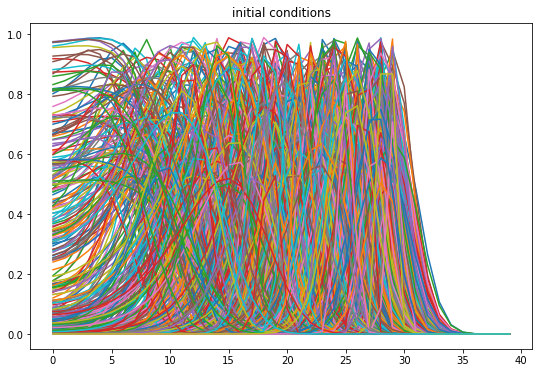

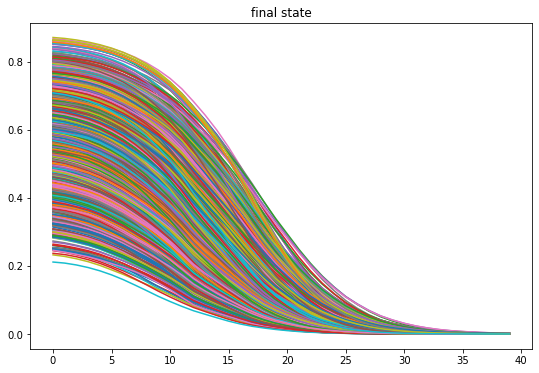

In [85]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()


for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('final state')
plt.show()

rdim:  20
prdim:  30
n_VAR_steps:  2
train shape:  (861, 399000)
target shape:  (30, 399000)
weights shape:  (861, 30)


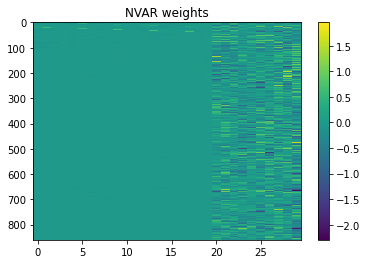

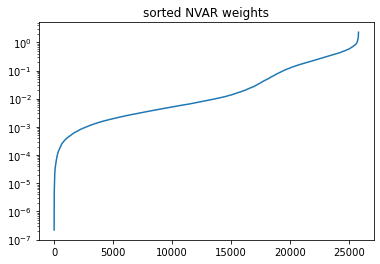

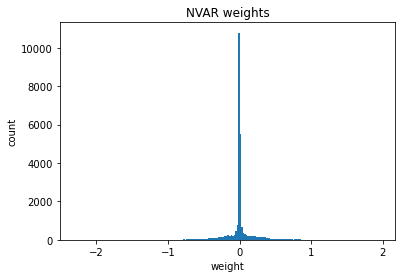

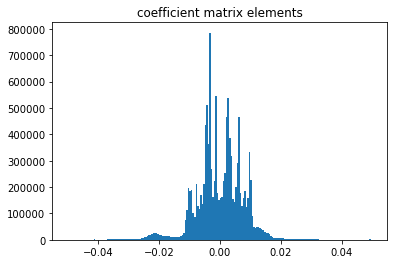

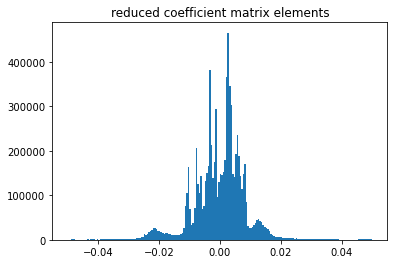

In [48]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.5)
# optimizer = ELPH_Optimizer.stlsq(alpha=10.**-3.5, threshold=1e-3)
scaler = ELPH_Scaler.normalize_scaler(0.1)
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

model = RDNLVAR(runs)
model.train(rdim=20, prdim = 30, n_VAR_steps=2, intercept=True, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=VAR_transformer)
model.print_status()

masked_weights = np.ma.masked_values(model.w,0.0)
plt.imshow(masked_weights, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(model.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(model.w), bins=200)
plt.title('NVAR weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

plt.hist(np.ravel(model.coef_matrix), bins=200)
plt.title('coefficient matrix elements')
plt.show()

plt.hist(np.ravel(model.coef_matrix[:model.rdim]), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

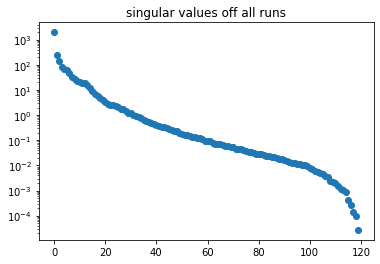

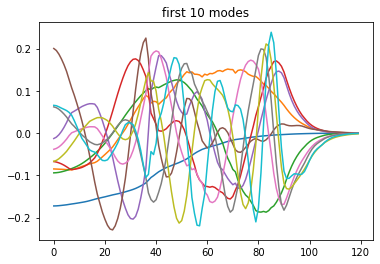

In [49]:
plt.semilogy(dim_reducer.S, 'o')
plt.title('singular values off all runs')
plt.show()

rdim = 10
for l in range(rdim):
  plt.plot(dim_reducer.U[:,l],  label='U_'+str(l))
plt.title('first ' + str(rdim) + ' modes')
plt.show()

In [50]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.5)
scaler = ELPH_Scaler.normalize_scaler(0.1)
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler, 'dim_reducer':dim_reducer, 'VAR_transformer':VAR_transformer }
score_kwargs = {'norm':'max'}


m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.02577645079609308
0.000747264093039729
[0.025920864227419873, 0.025480647659041507, 0.02464670609459837, 0.026958630228820266, 0.0258754057705854]


rdim:  20
prdim:  30
n_VAR_steps:  2
train shape:  (861, 398601)
target shape:  (30, 398601)
weights shape:  (861, 30)
error:  0.015526227947060434


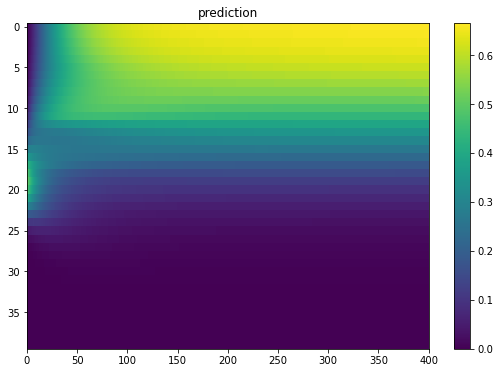

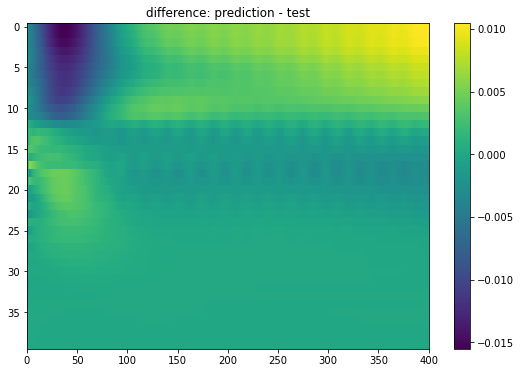

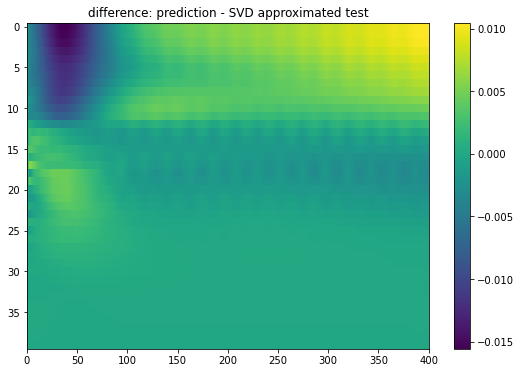

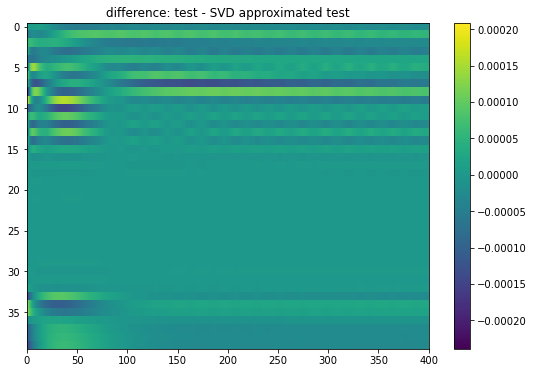

In [86]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.5)
scaler = ELPH_Scaler.normalize_scaler(0.1)
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

train_runs = runs[::1]
test_run = train_runs.pop(85)

model.load_runs(train_runs)
model.train(rdim=20, prdim = 30, n_VAR_steps=2, intercept=True, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=VAR_transformer)

model.print_status()


print('error: ', model.get_error(test_run, norm='max') )

pred = model.predict_single_run(test_run)

xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()


test_run_SVDapprx = dim_reducer.U[:,:30] @ dim_reducer.U[:,:30].T @ test_run

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()


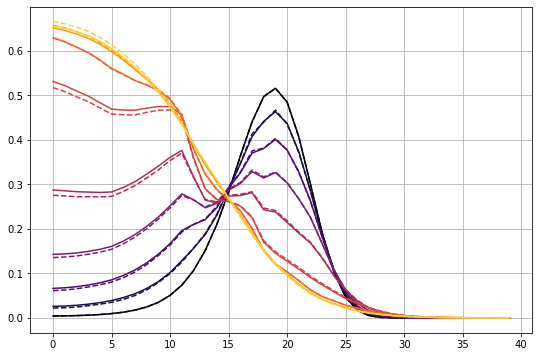

std error:  0.0035695150411215603
max abs error:  0.015526227947060434


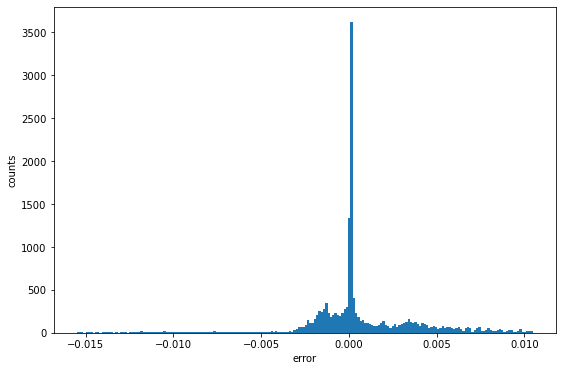

In [87]:
colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_run[:,tn], '-', c=colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=colors(k/len(tn_arr)))

plt.show()

print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max abs error: ', model.get_error(test_run, pred, norm='max') )

plt.hist(np.ravel(pred-test_run), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()

In [88]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.5)
scaler = ELPH_Scaler.normalize_scaler(0.1)
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

train_runs = runs[:950:1]
test_runs = runs[950::1]

model.load_runs(train_runs)
model.train(rdim=20, prdim = 30, n_VAR_steps=2, intercept=True, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=VAR_transformer)

model.print_status()

rdim:  20
prdim:  30
n_VAR_steps:  2
train shape:  (861, 379050)
target shape:  (30, 379050)
weights shape:  (861, 30)


max error:  0.02088295639533022
std error:  0.006223509289577114


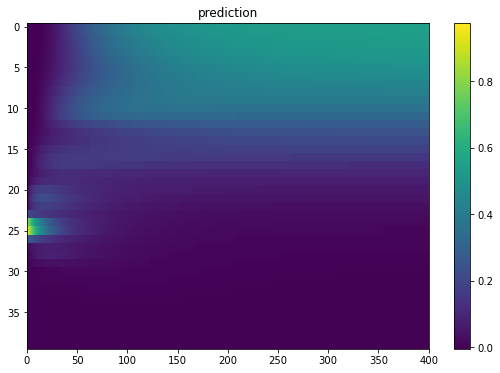

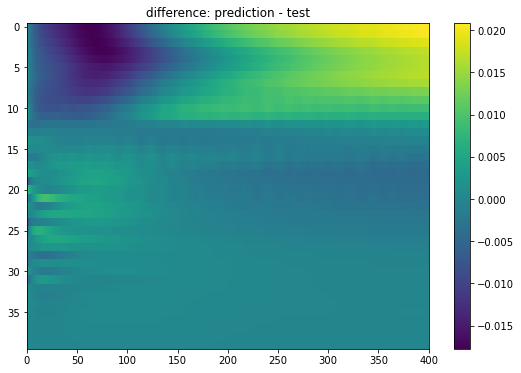

In [89]:

test_run = test_runs[11]

pred = model.predict_single_run(test_run)

print('max error: ', model.get_error(test_run, pred, norm='max') )
print('std error: ', model.get_error(test_run, pred, norm='std') )

xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()


# test_run_SVDapprx = dim_reducer.U[:,:30] @ dim_reducer.U[:,:30].T @ test_run

# plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
# plt.colorbar()
# plt.title('difference: prediction - SVD approximated test')
# plt.xlim(0,xmax)
# plt.show()

# plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
# plt.colorbar()
# plt.title('difference: test - SVD approximated test')
# plt.xlim(0,xmax)
# plt.show()


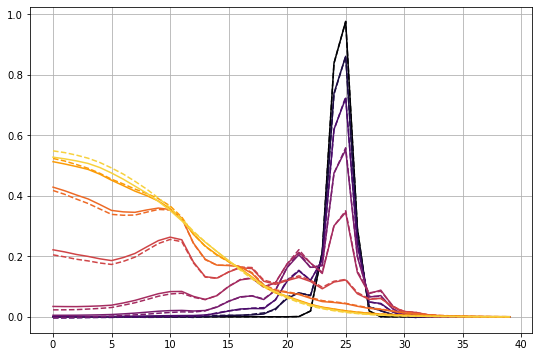

std error:  0.006223509289577114
max abs error:  0.02088295639533022


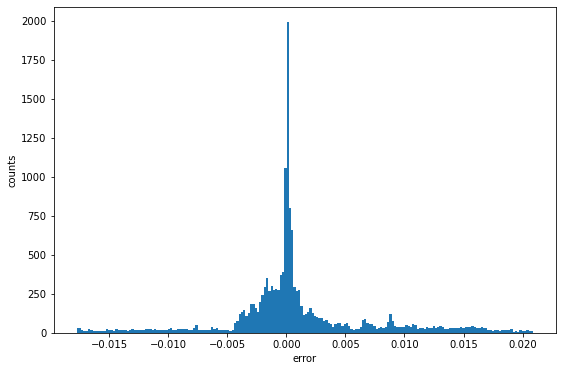

In [90]:
colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_run[:,tn], '-', c=colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=colors(k/len(tn_arr)))

plt.show()

print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max abs error: ', model.get_error(test_run, pred, norm='max') )

plt.hist(np.ravel(pred-test_run), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()

In [22]:
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.polynomial_features(order=2)

def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    optimizer = ELPH_Optimizer.ridge(alpha=alpha)

    
    train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler, 'dim_reducer':dim_reducer, 'VAR_transformer':VAR_transformer }
    score_kwargs = {'norm':'max'}
    
    m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

# print(get_score(-3.4, 0.1))

from bayes_opt import BayesianOptimization
pbounds = {'aExp':[-5, -1], 'rel_scale':[0.1,1.0]}
optimizer = BayesianOptimization(f=get_score, pbounds=pbounds, random_state=817)

optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   |   aExp    | rel_scale |
-------------------------------------------------
|  1        | -0.02597  | -3.007    |  0.3326   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_RDNLVAR.py:197: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ transform


|  2        | -10.0     | -4.485    |  0.3198   |
|  3        | -10.0     | -2.094    |  0.6728   |
|  4        | -10.0     | -2.661    |  0.4647   |
|  5        | -0.02733  | -3.044    |  0.1073   |
|  6        | -10.0     | -3.43     |  0.8916   |
|  7        | -10.0     | -2.31     |  0.8759   |
|  8        | -10.0     | -2.332    |  0.7215   |
|  9        | -10.0     | -3.123    |  0.6345   |
|  10       | -10.0     | -2.053    |  0.6786   |
|  11       | -0.02747  | -3.043    |  0.1049   |
|  12       | -0.02788  | -2.806    |  0.114    |
|  13       | -0.06102  | -1.0      |  0.1      |
|  14       | -0.02755  | -1.0      |  0.5286   |
|  15       | -0.02991  | -1.368    |  0.2373   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_RDNLVAR.py:197: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ transform


|  16       | -10.0     | -1.0      |  1.0      |
|  17       | -0.02752  | -1.002    |  0.5299   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_RDNLVAR.py:197: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ transform
incl/ELPH_RDNLVAR.py:197: RuntimeWarning: overflow encountered in matmul
  pred[:,j] = self.w.T @ transform


|  18       | -10.0     | -5.0      |  1.0      |
|  19       | -0.03521  | -1.773    |  0.1      |
|  20       | -0.02588  | -3.677    |  0.1      |
|  21       | -0.03231  | -2.165    |  0.1      |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_RDNLVAR.py:197: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ transform


|  22       | -10.0     | -3.848    |  0.4178   |
|  23       | -0.02651  | -3.411    |  0.1      |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_RDNLVAR.py:197: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ transform


|  24       | -10.0     | -5.0      |  0.1      |
|  25       | -0.02948  | -1.12     |  0.3306   |
|  26       | -0.02539  | -1.436    |  0.5434   |
|  27       | -0.0264   | -1.643    |  0.3411   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_RDNLVAR.py:197: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ transform


|  28       | -10.0     | -4.248    |  1.0      |
|  29       | -0.02752  | -1.002    |  0.5297   |
|  30       | -0.03085  | -2.447    |  0.1      |
|  31       | -0.03942  | -1.535    |  0.1      |
|  32       | -0.04775  | -1.236    |  0.1013   |
|  33       | -0.02533  | -3.995    |  0.1      |
|  34       | -0.02643  | -1.265    |  0.4845   |


/usr/lib/python3/dist-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
incl/ELPH_RDNLVAR.py:197: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ transform


|  35       | -10.0     | -1.535    |  0.9991   |
|  36       | -0.02586  | -3.225    |  0.2806   |
|  37       | -0.02644  | -1.475    |  0.392    |
|  38       | -0.02714  | -1.935    |  0.2289   |
|  39       | -0.02872  | -1.578    |  0.231    |
|  40       | -0.03329  | -1.973    |  0.1      |
|  41       | -0.02568  | -1.511    |  0.6552   |


KeyboardInterrupt: 